In [1]:
# !pip install prettytable

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
# from flaml import AutoML
# from sklearn.ensemble import HistGradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
# from sklearn.linear_model import ElasticNet
# from sklearn.tree import DecisionTreeRegressor

# from lightgbm import LGBMRegressor
from prettytable import PrettyTable
import sys  
import os
root_path = os.path.realpath('/..')
sys.path.insert(0, root_path)
%load_ext autoreload
%autoreload 2

from tw_experimentation.variance_reduction.diff_in_means import DifferenceInMeans
from tw_experimentation.variance_reduction.cuped import CUPED, multiple_CUPEDs, MultivariateCUPED
from tw_experimentation.variance_reduction.utils import create_pretty_table, query_snowflake, bootstrap_generator, subsample_generator, bootstrap_data, subsample_data, aaify, add_synthetic_effect
# from tw_experimentation.variance_reduction.mlrate import MLRATE, AltMLRATE
# from tw_experimentation.variance_reduction.cupac import CUPAC
# from tw_experimentation.variance_reduction.doubly_robust import DoublyRobustEstimator
from tw_experimentation.variance_reduction.evaluation_pipeline import VREvaluation, VREvaluationAll
from tw_experimentation.variance_reduction.multivariate_regression import MultivariateRegression, MultivariateRegressionAdjusted


# Simple synthetic data

In [3]:
def generate_synthetic_data(n):

    # pre experiment metric
    group_0 = np.random.exponential(10, n//2)
    group_1 = np.random.exponential(10, n//2)

    pre_metric = np.concatenate([group_0, group_1])

    # experiment metric
    ctrl_group_0 = group_0 + np.random.normal(0,1, n//2)
    treatment_group_1 = group_1 + np.random.normal(5,1, n//2) + np.random.normal(0,1, n//2)

    exp_metric = np.concatenate([ctrl_group_0, treatment_group_1])

    # treatment
    treatment = np.concatenate([np.zeros(n//2), np.ones(n//2)])

    # assemble dataframe
    df = pd.DataFrame({
        'Y': exp_metric,
        'T': treatment,
        'X': pre_metric
    })

    # shuffle
    df = df.sample(frac=1).reset_index(drop=True)

    return df


In [4]:
simple_synthetic_df = generate_synthetic_data(10000)

## MultivariateCUPED

In [5]:
MultiCUPED_params_map = {
    'MultivariateCUPED' : {
        'covariate_columns': ['X']
    }
}

In [6]:
multi_cuped_evaluation = VREvaluation(MultivariateCUPED)
multi_cuped_evaluation = multi_cuped_evaluation.run(data=simple_synthetic_df,
                                      treatment_column='T',
                                      target_column='Y',
                                      method_params_map=MultiCUPED_params_map,
                                      verbose=True,
                                      n_bootstrap=100)

Running MultivariateCUPED...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 122.51it/s]


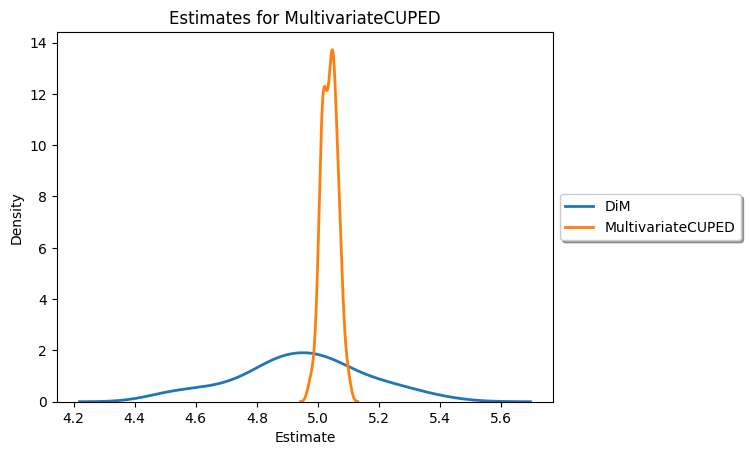

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Estimates for MultivariateCUPED'}, xlabel='Estimate', ylabel='Density'>)

In [7]:
multi_cuped_evaluation.plot(plot_what='estimates')

## CUPED vs MultivariateCUPED

In [8]:
cupeds_params_map = {
    'MultivariateCUPED' : {
            'covariate_columns': ['X']
        },
    'CUPED' : {
        'covariate_column': 'X'
    }
}

In [9]:
cupeds_evaluation = VREvaluationAll([CUPED, MultivariateCUPED])
cupeds_evaluation = cupeds_evaluation.run_all(data=simple_synthetic_df,
                                      treatment_column='T',
                                      target_column='Y',
                                      method_params_map=cupeds_params_map,
                                      verbose=True,
                                      n_bootstrap=100)

Running CUPED...


  9%|███▊                                       | 9/100 [00:00<00:01, 83.54it/s]

[2.47968102 1.00331385]
[2.52274306 0.99898904]
[2.4843372 1.0033202]
[2.49110394 1.00075928]
[2.52734432 0.99799793]
[2.53756372 0.99636716]
[2.47432816 1.00413   ]
[2.50135893 0.99983796]
[2.5027918  1.00059982]
[2.49125378 1.00030927]
[2.49348857 1.00186462]
[2.48217177 1.00345583]
[2.53979561 0.99663713]
[2.51816964 0.99978123]
[2.52162518 0.99827077]
[2.47489319 1.00280444]
[2.48998137 1.00075479]
[2.44791851 1.00473744]


 29%|████████████▏                             | 29/100 [00:00<00:00, 89.79it/s]

[2.50383495 0.99961044]
[2.45928363 1.00409764]
[2.48750737 1.00189093]
[2.50743937 0.99896153]
[2.50317823 0.99905738]
[2.49637539 1.00092608]
[2.52014202 0.9992774 ]
[2.49851551 1.00149433]
[2.48893502 1.00124924]
[2.45304031 1.00424348]
[2.45647993 1.00702079]
[2.51141002 0.99939368]
[2.46602979 1.00227999]
[2.52158982 1.00026978]
[2.47671827 1.00326202]
[2.51545429 0.99795981]
[2.50127129 0.99965692]
[2.48031983 1.00065269]
[2.43255175 1.00538943]


 49%|████████████████████▌                     | 49/100 [00:00<00:00, 92.07it/s]

[2.4746819  1.00410001]
[2.4552544  1.00284141]
[2.52980917 0.99763041]
[2.49966597 1.00114478]
[2.50671942 0.99973583]
[2.42904685 1.00765065]
[2.50264479 0.99875741]
[2.47013324 1.00330246]
[2.48744075 1.00156526]
[2.43568303 1.00731484]
[2.48995709 1.0021853 ]
[2.52334079 0.99944984]
[2.45901546 1.00397856]
[2.45894104 1.00147059]
[2.54527738 0.99641712]
[2.51669687 0.99975652]
[2.55058137 0.99671895]
[2.49985219 1.0014    ]
[2.51985385 0.99740449]


 69%|████████████████████████████▉             | 69/100 [00:00<00:00, 91.60it/s]

[2.46541279 1.0053332 ]
[2.4738703  1.00261652]
[2.51046199 0.99862885]
[2.5004564  1.00033186]
[2.48617733 1.00118646]
[2.47026992 1.00308618]
[2.5113055  0.99819701]
[2.52113418 0.99925517]
[2.52141148 0.99970447]
[2.54053759 0.99792753]
[2.49525636 1.00111965]
[2.51547618 0.99966732]
[2.53421352 0.99891636]
[2.494591   1.00324899]
[2.48830301 0.99926518]
[2.4693646  1.00310146]
[2.48915837 1.00240841]
[2.49963166 1.00181659]
[2.51792998 0.99980737]


 89%|█████████████████████████████████████▍    | 89/100 [00:00<00:00, 89.73it/s]

[2.48196405 1.00462737]
[2.52534603 0.9997588 ]
[2.49912    0.99944813]
[2.48856344 1.00132659]
[2.4922965  1.00008536]
[2.48110873 1.00112499]
[2.46164794 1.00424294]
[2.47951704 1.00219666]
[2.48366068 1.0011564 ]
[2.51642939 0.99820634]
[2.46468616 1.00468983]
[2.4857552  1.00151298]
[2.50635114 0.99953335]
[2.47942729 1.00243334]
[2.52436434 1.00050325]
[2.46733609 1.00441673]
[2.45148499 1.00256513]
[2.49128414 1.00281353]


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 89.19it/s]


[2.39998547 1.01069581]
[2.47235361 1.00086057]
[2.52699214 0.99882565]
[2.47785106 0.99931373]
[2.47501277 1.00357316]
[2.55541627 0.99560362]
[2.5096785  0.99742108]
Running MultivariateCUPED...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 131.95it/s]

Done!


In [10]:
cupeds_evaluation.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,CUPED,5.039593,"(4.9942972394630365, 5.086225374967744)",None,None,0.0,"(0.0, 0.0)",None,0.985074
1,MultivariateCUPED,5.039593,"(4.9942972394630365, 5.086225374967743)",None,None,0.0,"(0.0, 0.0)",None,0.985074


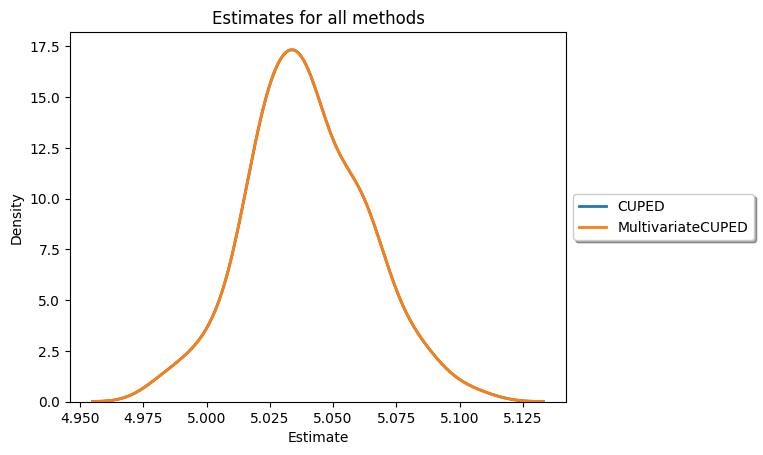

<Axes: title={'center': 'Estimates for all methods'}, xlabel='Estimate', ylabel='Density'>

In [11]:
cupeds_evaluation.plot(plot_what='estimates')

# Synthetic data MLRATE paper and other VR methods

In [12]:
def dgp(n=2000, p=10, linear=True, constant=True):
    """DGP from https://github.com/muratunalphd/Blog-Posts/blob/main/variance-reduction-methods/MLRATE.ipynb"""
        
    Xmat = np.random.multivariate_normal(np.zeros(p), np.eye(p), size=n).astype('float32')

    T = np.random.binomial(1, 0.5, n).astype('int8')

    col_list = ['X' + str(x) for x in range(1,(p+1))]

    df = pd.DataFrame(Xmat, columns = col_list)
    
    # functional form of the covariates
    if linear:
        B = 225 + 50*df['X1'] + 5*df['X2'] + 20*(df['X3']-0.5) + 10*df['X4'] + 5*df['X5']
    else:
        B = 225 + 50*df['X1'] + 5*np.sin(np.pi*df['X1']*df['X2'] ) + 10*(df['X3']-0.5)**2 + 10*df['X4']**2 + 5*df['X5']**3
    
    # constant ate or non-constant
    tau = 1.8 if constant else 5*df['X1'] + 5*np.log(1 + np.exp(df['X2']))
    
    # Y = (B + tau*T + np.random.normal(0,25,n)).astype('float32')
    Y = (B + tau*T + np.random.normal(0,25,n)).astype('float32')
        
    df['T'] = T
    df['Y'] = Y    
    return df

In [13]:
nonlinear_synthetic_df = dgp(n=2000, p=10, linear=False, constant=True)
linear_synthetic_df = dgp(n=2000, p=10, linear=True, constant=True)

## CUPED vs MultivariateCUPED

### Linear

In [14]:
linear_synthetic_df.cov()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,T,Y
X1,1.042087,0.000214,0.027764,-0.035909,-0.017001,0.018688,0.015074,-0.007500,-0.040218,0.015010,0.005251,52.298748
X2,0.000214,1.008077,0.006244,-0.012960,-0.014791,-0.004738,0.000066,0.022016,-0.032082,0.035778,0.001154,4.980175
X3,0.027764,0.006244,0.973995,-0.010585,0.044135,-0.028988,0.005401,0.002417,-0.045799,0.015900,0.004603,21.254778
X4,-0.035909,-0.012960,-0.010585,1.041467,0.014747,-0.017197,0.016255,0.026374,-0.011832,-0.017686,0.003646,8.688574
X5,-0.017001,-0.014791,0.044135,0.014747,1.009988,0.007857,-0.027062,-0.049076,0.031566,0.021080,0.006519,4.325619
X6,0.018688,-0.004738,-0.028988,-0.017197,0.007857,1.012145,0.006264,0.022080,-0.036490,0.013967,0.022487,-0.399050
X7,0.015074,0.000066,0.005401,0.016255,-0.027062,0.006264,0.983362,0.026089,0.068333,-0.003451,0.020902,1.072590
X8,-0.007500,0.022016,0.002417,0.026374,-0.049076,0.022080,0.026089,0.986180,0.020937,0.053518,-0.006737,-0.651040
X9,-0.040218,-0.032082,-0.045799,-0.011832,0.031566,-0.036490,0.068333,0.020937,0.979401,0.004531,0.016526,-2.906569
X10,0.015010,0.035778,0.015900,-0.017686,0.021080,0.013967,-0.003451,0.053518,0.004531,0.970260,-0.011093,0.816644


In [15]:
cupeds_params_map2 = {
    'DifferenceInMeans':{
    },
    'CUPED' : {
        'covariate_column': linear_synthetic_df.columns.to_list()[1]
    },
    'MultivariateCUPED' : {
            'covariate_columns': linear_synthetic_df.columns.to_list()[1:10]
    }
    
}

In [16]:
cupeds_evaluation2 = VREvaluationAll([DifferenceInMeans, CUPED, MultivariateCUPED])
cupeds_evaluation2 = cupeds_evaluation2.run_all(data=linear_synthetic_df,
                                      treatment_column='T',
                                      target_column='Y',
                                      method_params_map=cupeds_params_map2,
                                      verbose=True,
                                      n_bootstrap=100,
                                      true_ate=1.8)

Running DifferenceInMeans...


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1126.48it/s]


Running CUPED...


 24%|█████████▊                               | 24/100 [00:00<00:00, 236.32it/s]

[216.52970142   4.20068322]
[219.50301993   5.09773849]
[216.21283788   3.89436177]
[218.19073796   3.97932022]
[218.84972411   4.7966491 ]
[216.92938903   5.05234798]
[218.47500519   3.96171028]
[218.39568738   5.67519719]
[219.56556429   4.89367843]
[216.90061489   5.91176781]
[217.45386129   6.05179038]
[218.71985613   5.71845847]
[218.446533     6.35857906]
[218.48552148   5.6522848 ]
[219.78492623   5.38710252]
[217.71818407   3.87401516]
[218.8569626   3.9655692]
[216.55085981   3.90005914]
[216.64818861   2.48172955]
[220.03724328   4.50402798]
[218.32010178   3.89604571]
[219.84696631   6.24416074]
[221.31011867   3.92683835]
[218.51425865   5.54398202]
[217.87151443   5.47067883]
[217.18211807   4.34573331]
[216.45947775   6.67981606]
[217.16808624   5.01446216]
[219.61687924   4.38822019]
[219.73828554   6.91408642]
[220.3962709    3.48353205]
[217.80266677   6.56188088]
[221.14809061   3.66688069]
[218.84774147   6.23275273]
[217.17067807   2.82801553]
[218.42998756   5.7485

 72%|█████████████████████████████▌           | 72/100 [00:00<00:00, 236.82it/s]

[216.11706664   5.38135905]
[219.22771476   6.05930087]
[216.2707417    4.24871359]
[218.12237103   4.01302574]
[218.92985187   4.08836856]
[220.84387274   5.03822261]
[216.73001285   3.99575228]
[217.66158343   5.29140591]
[214.69902375   5.8849876 ]
[219.54975234   4.29350498]
[219.09172756   4.42865033]
[219.20873513   4.92472182]
[218.35285335   4.27630601]
[216.83368787   4.18634601]
[217.38234687   4.40766147]
[218.890435     4.40033896]
[217.95516102   6.18276227]
[217.5317837    3.14848454]
[217.10580676   3.41128278]
[219.72065735   6.30937153]
[218.44036368   4.57668563]
[219.6248801    2.85498756]
[218.06479662   4.19023557]
[219.03667871   4.40573584]
[217.13972519   4.76710633]
[216.43165749   6.91628634]
[218.340928     4.04691492]
[217.37343658   3.13083393]
[215.77395      4.85825307]
[220.80311002   6.45646095]
[217.98586942   5.46823072]
[217.94324166   3.21590557]
[217.39951018   6.79807614]
[218.68886362   5.81021057]
[219.03093499   5.56792991]
[217.92270662   3.43

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 235.41it/s]


[217.78439952   4.820663  ]
[218.15662575   6.84019721]
[218.10644092   5.6681943 ]
[216.07988696   4.16996169]
Running MultivariateCUPED...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 232.34it/s]

Done!


In [17]:
cupeds_evaluation2.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,DifferenceInMeans,4.927621,"(-0.15160879909178313, 10.14008547175105)",3.127621,"(-1.9516087990917832, 8.340085471751049)",0.178251,"(0.00024700102889624136, 0.8487447302849762)",0.00,0.000000
1,CUPED,4.917756,"(-0.06759466345810447, 10.08687391493001)",3.117756,"(-1.8675946634581044, 8.286873914930009)",0.180993,"(0.00025977716107208, 0.8398193036612794)",0.80,-0.009934
2,MultivariateCUPED,4.092297,"(-0.6868447979079705, 9.119904783418837)",2.292297,"(-2.4868447979079704, 7.3199047834188375)",0.217200,"(0.0003794777599128794, 0.828322036818245)",0.87,0.115209


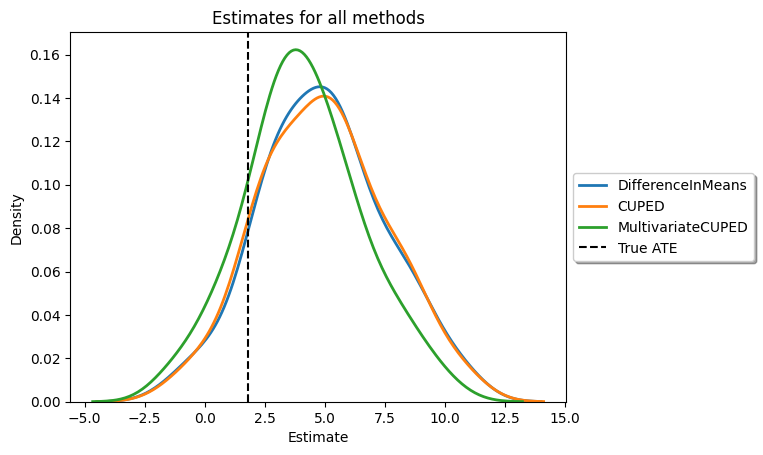

<Axes: title={'center': 'Estimates for all methods'}, xlabel='Estimate', ylabel='Density'>

In [18]:
cupeds_evaluation2.plot(plot_what='estimates')

### Non linear

In [19]:
nonlinear_synthetic_df.cov()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,T,Y
X1,1.033437,0.011998,0.009469,-0.031823,-0.028398,0.000413,0.006512,0.028353,0.015851,-0.007202,0.006835,51.649665
X2,0.011998,1.021121,0.000873,0.011626,-0.015159,-0.004210,-0.012658,0.005282,-0.044416,0.018539,0.011773,0.605708
X3,0.009469,0.000873,0.990997,-0.019276,-0.003584,0.043972,0.005156,0.015109,0.020724,-0.037811,0.003362,-10.830855
X4,-0.031823,0.011626,-0.019276,1.054474,-0.003387,-0.012726,0.021897,0.003154,0.011902,0.024932,0.001713,-1.761961
X5,-0.028398,-0.015159,-0.003584,-0.003387,0.978436,-0.005468,0.015413,0.002459,0.001601,0.034343,0.004115,14.848660
X6,0.000413,-0.004210,0.043972,-0.012726,-0.005468,1.101732,0.043709,0.027591,-0.029386,0.003008,-0.010086,0.033467
X7,0.006512,-0.012658,0.005156,0.021897,0.015413,0.043709,1.010249,-0.007740,-0.007945,-0.008984,0.006145,1.461487
X8,0.028353,0.005282,0.015109,0.003154,0.002459,0.027591,-0.007740,0.956167,0.024881,0.022230,-0.004065,0.743671
X9,0.015851,-0.044416,0.020724,0.011902,0.001601,-0.029386,-0.007945,0.024881,0.984263,-0.031075,0.005452,1.064846
X10,-0.007202,0.018539,-0.037811,0.024932,0.034343,0.003008,-0.008984,0.022230,-0.031075,0.993844,0.004079,0.860191


In [20]:
cupeds_params_map3 = {
    'DifferenceInMeans':{
    },
    'CUPED' : {
        'covariate_column': nonlinear_synthetic_df.columns.to_list()[0]
    },
    'MultivariateCUPED' : {
            'covariate_columns': nonlinear_synthetic_df.columns.to_list()[0:5]
    }
    
}

In [21]:
cupeds_evaluation3 = VREvaluationAll([DifferenceInMeans, CUPED, MultivariateCUPED])
cupeds_evaluation3 = cupeds_evaluation3.run_all(data=nonlinear_synthetic_df,
                                      treatment_column='T',
                                      target_column='Y',
                                      method_params_map=cupeds_params_map3,
                                      verbose=True,
                                      n_bootstrap=1000,
                                      true_ate=1.8)

Running DifferenceInMeans...


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1149.70it/s]


Running CUPED...


  2%|▉                                       | 24/1000 [00:00<00:04, 236.14it/s]

[248.10577737  50.9644153 ]
[246.17163507  50.10192029]
[247.79097745  51.27785336]
[247.836439    50.81077729]
[248.07000605  50.51980318]
[248.18353329  48.965247  ]
[248.00139048  50.81554321]
[248.27664771  49.81981589]
[249.30041567  50.16246822]
[247.70837251  50.433888  ]
[247.516941    49.04108108]
[248.48341318  50.65582035]
[248.69511915  51.58338462]
[247.5393434  51.1325566]
[247.3723527   50.79939508]
[248.33004373  50.22277496]
[248.01386537  49.76823949]
[248.37366929  51.26665847]
[248.24010863  51.28890551]
[248.27454371  49.39665836]
[249.27964034  51.43164127]
[247.6406707  49.5996486]
[246.81317547  49.58529929]
[247.06963657  50.68298657]
[247.62553688  50.68568044]
[248.33918113  51.04626179]
[248.84987875  50.37803589]
[249.61860611  50.5051828 ]
[248.80597386  52.52261327]
[247.20496855  49.69939079]
[249.47402796  50.45664087]
[247.67277084  48.99328341]
[248.29508211  49.53282283]
[249.44287374  49.50492857]
[247.77059327  49.58335279]
[247.48078951  50.329683

  7%|██▉                                     | 72/1000 [00:00<00:03, 234.75it/s]

[248.01168351  50.77268526]
[247.68954794  48.93278783]
[247.24769231  51.81959055]
[247.49652474  48.7355726 ]
[246.65606564  49.16180171]
[247.65919087  48.58776119]
[248.42749745  50.31633653]
[248.14302474  49.74250777]
[249.13386346  50.10164624]
[247.49131323  49.54822756]
[247.17604548  48.59696481]
[245.98864446  49.21934751]
[247.29723356  50.48558317]
[247.47097668  48.30387405]
[248.50074348  49.47712768]
[246.91592405  50.74602902]
[248.49573701  50.68152226]
[246.94819958  48.93728446]
[247.73426863  49.33253023]
[248.57910829  50.35325613]
[248.12621361  48.31878074]
[247.22792155  48.12360744]
[247.33823292  49.22876757]
[247.45884883  50.44006662]
[247.50230628  49.36741246]
[247.67555469  47.68254963]
[247.81973528  49.8951494 ]
[248.19824269  49.61477873]
[247.24099489  49.78328445]
[248.48934509  49.42600277]
[248.62607332  50.222054  ]
[245.45118297  50.2841262 ]
[246.84759693  50.21779702]
[247.93258976  49.47029445]
[247.06978132  50.2228577 ]
[248.49716533  50.62

 12%|████▋                                  | 120/1000 [00:00<00:03, 236.45it/s]

[248.19933799  50.83166447]
[248.01294104  49.47929342]
[246.86081047  49.48363125]
[246.71923035  50.72419049]
[248.30503417  50.96195631]
[248.43350328  48.64356831]
[247.66001077  49.82385242]
[247.38811803  49.44076031]
[248.03570302  48.56854759]
[246.15246549  48.25099704]
[247.82928574  50.5869248 ]
[247.08415618  48.88827834]
[247.74078691  49.14066115]
[246.45201934  48.69929846]
[247.6170964  51.859424 ]
[248.70928135  49.92804419]
[247.73652663  50.42345849]
[247.94174497  52.67522772]
[247.8942655   51.65115666]
[249.22526186  51.32914654]
[246.26809638  48.83111918]
[248.073116    49.88287316]
[249.68298854  50.37278058]
[247.67585411  50.15664507]
[247.38001332  49.3179505 ]
[249.67691918  50.19661365]
[248.82387912  49.3844261 ]
[248.64256079  49.43801429]
[247.01957815  50.56879518]
[247.61263989  48.46896783]
[248.3747997   48.54028291]
[249.54916876  51.16164752]
[248.31292865  48.82025267]
[246.29989976  49.15129602]
[246.84496389  49.48855105]
[248.45950845  49.4937

 17%|██████▋                                | 170/1000 [00:00<00:03, 238.83it/s]

[249.11682986  48.79694176]
[247.41090671  48.88519784]
[248.47112459  51.20259114]
[247.37750056  49.10075876]
[246.99423243  50.2105174 ]
[248.47592595  50.17763806]
[247.02176021  50.81826868]
[247.63598672  48.98028806]
[248.0875065   49.32960526]
[248.24937813  48.74015066]
[250.54003822  50.74588974]
[246.90265808  48.24097197]
[247.66746177  49.44194978]
[246.26703624  48.78828465]
[247.14388914  49.37648201]
[246.43037669  48.18073501]
[248.27640617  50.42358895]
[248.07165761  47.82603565]
[247.93467765  50.77296227]
[247.38918069  49.78334934]
[248.78217033  49.00564512]
[247.27583665  50.11587083]
[246.71262682  51.34848631]
[248.09959291  52.50108221]
[247.41762315  49.72408639]
[247.57657943  51.02942919]
[249.66838919  50.37931358]
[247.83706254  49.70190104]
[247.22711436  50.21155049]
[247.43427783  49.45905541]
[247.31428648  50.50161319]
[247.63784643  50.36986449]
[247.59631729  48.93745387]
[247.41066317  51.16907557]
[247.74230638  50.98795937]
[247.60465845  51.08

 22%|████████▌                              | 219/1000 [00:00<00:03, 239.44it/s]

[248.6936185   49.81077489]
[248.89105187  50.33021676]
[248.65869799  48.64092943]
[246.76745309  49.87085135]
[247.80812703  48.14582092]
[249.52642736  49.48471908]
[248.00331723  51.52446934]
[247.24297525  49.35894655]
[247.45308784  50.25579449]
[248.26759065  50.4902877 ]
[247.4647347   47.73998208]
[247.18515061  47.98268142]
[247.25332441  48.89009348]
[246.26430969  48.15457973]
[246.5042312   48.07295893]
[246.98463063  51.12129537]
[246.91119585  49.52582812]
[248.09792936  49.53142492]
[247.77447038  50.19792456]
[248.5119772   49.88143102]
[248.97158682  49.91198386]
[247.34382951  49.84088599]
[247.11357793  50.15022998]
[247.66232825  49.89210211]
[247.21411993  50.17581084]
[247.70966628  48.38227533]
[248.32720237  48.963933  ]
[247.10276328  48.41626344]
[247.49737879  49.051026  ]
[248.06193249  49.64471976]
[246.88703683  50.67693403]
[246.68731818  51.21825686]
[247.05592969  49.34775584]
[246.90643489  49.44475564]
[249.23569757  49.25439186]
[248.24581747  49.71

 27%|██████████▍                            | 267/1000 [00:01<00:03, 232.67it/s]

[248.80171726  50.28425143]
[247.93350786  49.40066142]
[247.67627881  49.73829573]
[246.3383926  49.435533 ]
[248.26604493  49.48663032]
[246.60488516  50.11876959]
[247.39364877  49.16507026]
[248.05350624  50.35025388]
[246.71843355  48.45548294]
[248.0055739   49.48869277]
[247.58723948  50.12525337]
[248.38588053  50.72411228]
[247.15292678  49.67010556]
[248.96537141  49.49293747]
[248.35713287  52.32099958]
[248.27999765  50.57130775]
[249.66298588  50.80706313]
[249.28791211  51.38887771]
[247.59793694  48.60762243]
[248.45897213  49.1563524 ]
[248.358997   51.2527117]
[247.67525095  50.58249166]
[247.17357566  48.86761478]
[247.74028402  50.17738484]
[247.0928624   50.40264336]
[247.82822171  52.30708775]
[247.75256784  47.49445469]
[247.54976898  50.01980087]
[248.16656521  51.20936304]
[247.76941169  50.73497879]
[250.34433067  49.05896766]
[248.11938781  50.33246191]
[247.14045809  48.01760106]
[247.53851928  51.10622341]
[247.22056993  50.95381913]
[247.96025859  50.913630

 32%|████████████▎                          | 315/1000 [00:01<00:02, 229.64it/s]

[248.74642364  49.98939149]
[249.15408769  49.25823032]
[248.25145528  50.64683885]
[246.16098562  50.82577145]
[249.53197801  52.4055292 ]
[247.51564735  51.24107609]
[248.38880411  50.66101449]
[248.53940387  49.70782536]
[247.56566208  51.0268775 ]
[249.45712781  52.02715643]
[247.57434074  51.38763525]
[246.94725666  51.61833076]
[246.53836638  48.95046029]
[247.70823193  50.61465047]
[248.0519237  49.7479609]
[246.21604031  48.6627714 ]
[247.74083122  49.20679105]
[247.75806866  51.12664057]
[247.8898884   51.77365298]
[249.3681746   51.37609075]
[246.49965894  49.71939461]
[247.23238304  48.99540648]
[248.3609627   50.58366372]
[249.50964161  49.75335792]
[247.37020767  50.83233667]
[247.08112296  49.0164772 ]
[249.50813599  50.32295883]
[246.58188172  49.34108537]
[247.82049151  50.33309703]
[247.7741533   50.34422271]
[248.97389028  51.210221  ]
[248.35269463  49.32439849]
[247.81174775  49.13611752]
[247.31552179  49.06526446]
[248.23319982  49.90929439]
[247.29674823  50.9910

 36%|██████████████                         | 360/1000 [00:01<00:03, 200.95it/s]

[247.44901681  49.55254165]
[248.03966631  50.16133273]
[248.11687831  50.86031473]
[247.36846805  50.93773424]
[247.83922283  47.77457663]
[248.21096419  50.67209032]
[247.59957008  50.43469679]
[247.50864975  49.69383862]
[246.50312984  49.59186237]
[248.84737493  50.72269156]
[248.23617364  47.66408416]
[247.59620628  49.85166975]
[249.62238216  51.53381433]
[246.06624873  47.70210877]
[247.93933387  50.99707918]
[248.86269916  50.04093083]
[247.06828734  51.30049081]
[247.88432387  50.20391867]
[247.98464089  49.09964224]
[248.03914273  49.26242344]
[247.89788937  47.20273462]
[247.74450249  47.91698584]
[246.90801478  50.27614052]
[248.81854712  49.607944  ]
[247.29433388  50.95673111]
[246.70571774  49.18731373]
[248.42691017  48.7786611 ]
[247.19100436  49.86767617]
[247.78311441  50.91442505]
[248.04682712  49.63380812]
[249.02532686  49.3956938 ]
[248.10975944  48.41520993]
[247.74022358  48.87973787]
[247.80985083  49.35787178]
[246.05070815  50.42206859]
[246.96299413  48.15

 40%|███████████████▋                       | 401/1000 [00:01<00:03, 193.54it/s]

[248.69520241  50.73532383]
[247.38251519  49.86524978]
[247.33031267  49.9168871 ]
[248.0961177   50.00235926]
[248.07083508  49.46146216]
[247.30052003  48.37462092]
[247.98334551  51.24621718]
[249.50020785  51.1743752 ]
[247.84565803  51.61331972]
[248.38103301  51.53762381]
[248.66941693  49.69300789]
[247.81830354  48.50191292]
[248.78855092  50.84547681]
[248.02573262  48.25445746]
[247.67825971  49.86485956]
[248.69556431  51.00153752]
[247.30200641  49.76815957]
[246.82476456  48.21338384]
[247.48299295  49.10744521]
[246.64445052  48.75542837]
[248.41778133  49.61395866]
[247.36956107  50.17424524]
[247.48314017  52.34021643]
[248.04279566  50.50292982]
[248.54853096  48.94071611]
[248.44732291  52.19556143]
[247.43279859  50.46213863]
[246.8866972   49.17550118]
[247.25805156  49.61964127]
[247.94363076  49.38758626]
[247.33950808  49.48378881]
[247.37638748  50.10041909]
[248.55719281  50.61699486]
[247.39799884  48.87835369]
[249.12199122  49.31158263]
[248.94034629  50.60

 44%|█████████████████▏                     | 441/1000 [00:02<00:02, 194.11it/s]

[247.91000856  49.63433925]
[247.69672833  50.69913697]
[247.41136482  50.11181484]
[245.96163667  48.73918906]
[248.01463896  48.93927388]
[247.55133738  51.4017647 ]
[247.9650556  49.9279982]
[248.34278337  50.46402548]
[248.94783297  50.03999617]
[248.21407942  51.79831122]
[247.52071744  48.98994278]
[246.31084591  49.81143596]
[249.07293661  48.95511504]
[247.87899424  51.04948087]
[247.5465127   50.85393019]
[247.72809584  50.5789576 ]
[247.86764826  49.37974979]
[247.33066486  49.51047729]
[248.37774478  51.16816404]
[247.50825058  52.05171821]
[247.28426301  48.98049265]
[245.95261653  50.50423392]
[247.87743954  49.9823879 ]
[246.45302828  48.92828204]
[246.84822059  49.31059189]
[249.02911564  48.98265714]
[247.0886889   49.83935688]
[245.76315367  48.93453568]
[247.60764923  49.00648218]
[248.07982437  49.47875718]
[247.38222389  50.89385097]
[246.05517464  50.81242744]
[246.74399568  51.25950846]
[246.64594288  50.62253872]
[247.80802283  50.23870865]
[247.83654876  51.9730

 46%|█████████████████▉                     | 461/1000 [00:02<00:02, 181.41it/s]

[247.06091939  49.97231894]
[246.45811788  48.7238649 ]
[247.49077833  50.01703289]
[246.9466742  49.1782527]
[248.04161718  47.66161765]
[247.49781907  50.11462746]
[246.32842981  48.81320475]
[247.80076656  47.85122217]
[249.17371232  50.01283355]
[247.23220244  49.02911783]
[248.59214332  49.34721814]
[247.55123412  48.43550435]
[247.55397114  49.23906451]
[247.4377782   50.91228412]
[247.69442726  50.3562964 ]
[246.20847989  50.65893966]
[245.92341182  48.90817299]
[247.82591296  50.33676027]
[247.62940336  49.44125254]
[247.71967907  49.98389424]
[247.31038918  50.86752713]
[246.85570882  50.63710101]
[246.45839107  48.87235904]
[248.62906618  51.23371787]
[248.68007131  50.56651541]
[246.70586632  48.61583667]
[247.12883789  50.36173232]
[248.45814454  49.39647449]
[247.19466765  49.35834691]
[246.48208669  50.19377301]
[247.30354977  48.03858623]
[247.44105252  49.17743334]
[249.28230303  51.68426159]
[247.48825771  49.91447102]
[248.76957941  50.4489849 ]


 50%|███████████████████▌                   | 501/1000 [00:02<00:02, 186.65it/s]

[246.89873748  50.79452775]
[247.27502187  49.32805863]
[248.38364221  50.89630329]
[247.76363795  50.97138852]
[247.04973289  50.95322955]
[247.61350533  48.63729707]
[247.64762201  50.70295039]
[250.06178597  49.7644559 ]
[246.61157645  49.16099302]
[248.36142487  48.8795713 ]
[247.12180191  48.47769199]
[248.42427388  51.24321106]
[248.66402802  50.42980476]
[248.23790705  50.2186974 ]
[247.71171454  49.40072798]
[247.06392903  49.97447648]
[246.47439234  50.76568961]
[247.33389078  48.89044457]
[247.61136714  52.24804031]
[248.04976226  50.28460915]
[248.0260075   48.50676975]
[247.835802    50.02897596]
[247.18914532  49.35058905]
[247.73618916  49.66852492]
[248.81066016  51.17240617]
[247.90505888  50.13695621]
[247.01320411  51.53541696]
[247.37040301  49.98006784]
[247.68614546  49.53436308]
[246.68320516  48.70238089]
[246.97997387  51.0959058 ]
[249.51900369  51.35597351]
[247.52275423  48.9077392 ]
[247.40671056  48.90746703]
[248.7220295   47.71378603]
[246.76301579  50.42

 54%|█████████████████████                  | 541/1000 [00:02<00:02, 190.84it/s]

[248.94610459  51.21828641]
[245.77900452  48.2237977 ]
[248.7217374   49.17530785]
[246.7429309   50.62604057]
[244.57830345  49.63278853]
[248.4211362   52.73980095]
[246.43729072  50.32083458]
[248.34555631  51.26857706]
[247.351098   50.6041551]
[248.17486313  49.55995211]
[246.90677596  48.80456604]
[247.09171731  49.41991108]
[247.93404928  48.95384738]
[248.62596586  50.04231182]
[246.81107243  50.44409679]
[248.66297407  49.20109248]
[248.44864676  50.46338233]
[247.09025083  49.01674738]
[248.48933439  50.33712824]
[248.2406808   49.52071393]
[248.26593351  48.89463078]
[248.58393607  50.14513744]
[248.05668793  50.70305852]
[247.81305313  51.09773709]
[248.30018199  51.93861165]
[248.97011655  50.90780545]
[248.15777371  50.31709006]
[246.27380474  48.9588431 ]
[248.03704883  49.3735328 ]
[248.44233474  50.85380232]
[249.33127418  50.05018341]
[249.59945006  50.40737509]
[248.54244686  49.97050426]
[246.7179939  49.0987787]
[248.71709127  50.28888495]
[247.61245463  49.595585

 58%|██████████████████████▋                | 583/1000 [00:02<00:02, 197.20it/s]

[248.77024541  49.23046868]
[246.21328293  50.21745916]
[247.21733402  50.31819221]
[246.74665051  48.84736337]
[247.70524693  51.07952625]
[249.27365354  51.12266439]
[248.46222008  49.3246285 ]
[247.93908111  50.94726943]
[247.42502949  51.07584407]
[247.83646185  50.63770699]
[249.10704969  49.25494648]
[247.23559859  51.76012538]
[248.11000524  49.18393774]
[248.62286181  50.10820092]
[247.46120847  50.37892649]
[246.65101322  50.42285067]
[247.70879542  48.8903687 ]
[248.99963149  52.12781966]
[246.79626041  48.4827812 ]
[247.39057166  49.16233268]
[247.70620176  49.70737678]
[247.93677182  49.47093638]
[247.72177788  49.75365457]
[248.76314981  50.04298143]
[247.92532159  48.87021509]
[247.53851928  50.35535751]
[247.17020561  50.4519649 ]
[247.65835147  49.68916399]
[248.99246334  48.88833918]
[246.9750608   51.40208288]
[247.27706359  48.88335928]
[249.17269889  48.99411914]
[247.60151491  49.08426061]
[247.03453896  49.99176537]
[247.06384252  50.77560073]
[248.76679406  51.14

 63%|████████████████████████▌              | 630/1000 [00:02<00:01, 214.58it/s]

[247.79274226  51.48144559]
[246.83539417  50.64323989]
[247.17192919  50.43323006]
[247.46773849  51.30434245]
[246.3158075   48.91460882]
[247.25149416  50.3160173 ]
[247.19363528  49.45459412]
[248.58865816  50.99197225]
[247.78120971  50.7047247 ]
[247.68523918  49.07004296]
[247.47152075  50.40072865]
[248.45639601  48.83582995]
[249.04330497  49.44767618]
[247.7986287   51.16532317]
[246.94190473  48.85307661]
[248.40680009  48.16493235]
[248.08223331  49.10702758]
[249.22948485  50.94261039]
[248.19196474  51.88298364]
[247.52018943  48.79828603]
[246.51663461  49.90367417]
[246.96367477  49.9950894 ]
[248.16444696  48.65234663]
[248.56997867  50.32087963]
[249.19110074  49.08239695]
[249.512914   48.3339751]
[247.98395199  48.5377173 ]
[246.52112971  52.12061507]
[248.73238241  49.87966136]
[247.84075548  49.39935291]
[249.12805725  51.00335451]
[247.37692438  50.9319336 ]
[247.09509826  49.53682064]
[246.45348504  48.71954003]
[247.36471051  50.67802865]
[248.8996437   49.2689

 68%|██████████████████████████▍            | 677/1000 [00:03<00:01, 221.46it/s]

[246.67073299  48.78940966]
[247.72745964  49.58808352]
[247.49031991  49.22615062]
[246.67021653  49.52160882]
[247.22190969  50.0076617 ]
[247.07010183  50.04701897]
[248.0662881   50.55881972]
[247.93805102  47.81732293]
[246.38619211  48.81072626]
[248.88114708  50.13629502]
[248.80316707  49.53633219]
[246.85771557  48.96883047]
[249.21281081  49.0196043 ]
[247.32903202  52.63929907]
[250.12013244  50.60942514]
[248.94607336  49.29171385]
[246.57938287  48.96871466]
[248.15587334  49.32071671]
[247.21363235  48.52162402]
[246.46572928  49.33469255]
[247.31258246  49.0335294 ]
[249.07021701  51.01430629]
[247.52414713  50.25989667]
[247.44362515  49.11637917]
[248.77182749  50.45969236]
[248.85094038  50.57370568]
[248.06670264  49.83617174]
[248.07369681  49.13331907]
[248.05314556  50.75152086]
[247.2963358   50.69670395]
[248.2638315   51.41952067]
[247.28195984  50.58582965]
[248.31656269  48.17938813]
[247.72767275  49.70979194]
[247.2428688   49.83814039]
[246.60735452  52.25

 72%|████████████████████████████▏          | 723/1000 [00:03<00:01, 223.64it/s]

[248.10867414  51.05436934]
[247.92558792  49.37260587]
[248.13160466  50.24312485]
[249.01666072  51.34060468]
[247.49888739  49.54797889]
[247.45376027  50.4745817 ]
[247.09153529  48.29089805]
[248.76096746  49.27286867]
[248.2400537   50.57284128]
[247.60582808  49.51239787]
[249.08848798  50.39915167]
[247.15686117  49.96347261]
[249.62727284  50.11276445]
[247.5086995   49.83609924]
[247.59814929  50.64150853]
[247.15245524  50.69912895]
[247.88250171  47.46234334]
[247.66598276  49.94296595]
[247.86366021  49.30842615]
[247.76268845  50.40924581]
[247.46330421  50.81011374]
[248.38751326  50.21842626]
[248.25215003  51.96136145]
[247.40042722  48.14759994]
[247.8994873   50.18470531]
[250.14607127  50.97624887]
[245.39732166  48.28938787]
[248.06051032  49.873668  ]
[246.99760112  49.57827134]
[247.33550002  48.3794132 ]
[248.67506225  49.90943172]
[248.2481472   49.77589859]
[247.55445543  49.76383496]
[246.1789867   51.71593893]
[248.88600631  50.53358108]
[247.14557539  49.73

 77%|█████████████████████████████▉         | 769/1000 [00:03<00:01, 217.12it/s]

[248.34055375  50.47210786]
[249.06135696  51.29585121]
[247.31451776  50.04483044]
[247.2765607   48.28175445]
[248.64390182  50.34325605]
[246.51562624  48.93306641]
[247.44323184  48.40771056]
[248.51411233  50.52655634]
[247.72304055  50.04340391]
[249.03230302  49.54446453]
[247.04140545  51.75107205]
[248.86132785  50.39767136]
[246.08008094  49.06245373]
[245.59678534  49.80326366]
[247.23565076  50.36777157]
[246.46693068  50.73005378]
[247.83218509  52.10921545]
[248.11904829  49.69794279]
[247.56830048  50.35791119]
[247.31814881  50.54455546]
[248.98614055  50.91942719]
[247.13377148  49.29143166]
[248.16558769  51.16164433]
[249.65810899  50.21628923]
[248.00513364  47.96707112]
[247.63610373  50.82563055]
[248.72416279  49.79184418]
[247.03684115  49.69725323]
[248.77866201  49.3523745 ]
[246.54458457  48.94255257]
[247.63227399  49.62503845]
[247.35675136  49.22886903]
[249.22658214  49.74959631]
[248.07331375  51.01368982]
[248.06809737  50.88895935]
[247.69877176  49.90

 81%|███████████████████████████████▋       | 813/1000 [00:03<00:00, 216.67it/s]

[249.18933997  51.59299509]
[247.14795532  50.5663166 ]
[248.37334772  51.88830129]
[246.94170664  47.42258912]
[247.71675333  48.37450861]
[247.47434497  49.32188546]
[248.9783702   48.97028966]
[246.9577477   49.12928937]
[247.72339789  47.64413916]
[247.44550189  51.22821203]
[247.25805286  50.414337  ]
[247.56006322  50.00493572]
[247.12563521  50.69553549]
[248.14227511  49.60842257]
[246.19403679  49.85478105]
[248.84868651  51.26334201]
[248.90856838  50.68486774]
[245.93161796  49.99230755]
[248.71526497  51.04264413]
[247.70587912  49.48063108]
[247.58245453  50.2190412 ]
[247.60852662  49.29588918]
[246.78311953  50.49405745]
[247.37344151  49.71324853]
[247.91736099  52.12864527]
[246.31383294  48.44490364]
[247.40766303  49.06700448]
[247.15862443  48.8141515 ]
[248.60534038  48.05947088]
[246.42037338  49.57724632]
[246.67541742  51.50658102]
[247.79650981  49.94351247]
[248.17816204  49.53122636]
[247.73793407  50.14952041]
[248.30529728  49.44166772]
[249.14818679  50.43

 86%|█████████████████████████████████▌     | 860/1000 [00:04<00:00, 223.90it/s]

[247.41185042  49.99609819]
[247.93045729  49.17520067]
[247.74524887  50.9605243 ]
[248.07488836  51.05159267]
[248.11903842  52.46833559]
[248.49116761  49.82590506]
[249.78882414  52.39176687]
[247.5455117   49.16858274]
[247.44795988  50.76545611]
[246.56757139  48.84577111]
[249.1239439  49.8692154]
[248.42093656  51.25214441]
[248.46825778  49.95258258]
[248.73076959  51.34765404]
[247.68677398  49.86304525]
[247.50545868  49.27736202]
[247.84983899  49.87433405]
[247.52456953  49.01171444]
[247.86979343  51.08300254]
[246.51545995  49.96592855]
[247.77862062  50.08143517]
[246.80952594  48.82736295]
[250.26374104  52.10284601]
[246.84116138  50.8205272 ]
[248.54504201  50.55051775]
[248.36732925  48.22459115]
[247.66518779  49.11956019]
[247.2087255  50.5625661]
[248.01389512  48.87190875]
[245.01862397  48.3548799 ]
[247.96497605  49.59074583]
[246.59090151  49.44847528]
[247.96136473  51.22681605]
[246.66004843  50.91620121]
[248.20000984  50.33114562]
[248.03287395  52.665352

 91%|███████████████████████████████████▎   | 907/1000 [00:04<00:00, 226.39it/s]

[249.76702995  51.9768933 ]
[248.40465505  49.33379455]
[250.21744027  51.16995171]
[247.73983224  48.98158529]
[247.23136152  49.22793639]
[246.03834852  50.47450413]
[247.27551829  50.11223237]
[248.44798965  49.80123025]
[247.8052787   51.67432761]
[246.6775639   49.77189051]
[248.0640231   49.50839695]
[249.33451212  49.78853454]
[248.78571174  50.35992159]
[247.6242354   48.41809057]
[247.57346627  50.88057454]
[248.43499103  50.00475915]
[248.60172415  51.67144337]
[249.37448394  50.37696871]
[246.1008534   50.41942883]
[250.03886659  50.10183181]
[248.83546363  49.45820642]
[248.91617379  51.13296259]
[248.1744684   48.90505055]
[247.85223787  48.77066212]
[247.83858434  51.12871385]
[248.68421554  50.65904794]
[247.373503    50.84870337]
[247.68521541  50.1629485 ]
[248.61994323  51.71668026]
[246.75402624  49.92640238]
[248.25689641  51.82713147]
[248.03857825  50.21019708]
[248.61965836  51.94452167]
[248.28043541  49.33051773]
[250.09083555  51.20646627]
[247.8797013   50.54

 96%|█████████████████████████████████████▏ | 955/1000 [00:04<00:00, 231.23it/s]

[247.64552623  50.01528044]
[248.42806639  50.82467376]
[248.22995348  49.76314955]
[249.86137405  51.05625989]
[248.46501659  48.23455611]
[245.93426795  49.61558781]
[246.42667124  51.3585842 ]
[248.7087864   50.61205675]
[248.31301026  50.07127538]
[248.34241084  48.62598484]
[247.53403568  49.21163757]
[248.15759316  49.41593357]
[246.79986948  50.63011579]
[248.03343303  49.64026609]
[247.97377626  49.93197189]
[247.48277143  50.30833606]
[248.60370636  50.52703489]
[248.76332265  49.76698383]
[247.28675538  50.21306922]
[248.63346564  49.05778062]
[246.07038053  48.93438386]
[248.38332727  48.5792276 ]
[248.5346816   49.44189807]
[248.05767915  51.04100579]
[247.43066999  50.0259716 ]
[248.50648493  49.41888041]
[248.17439587  49.31450579]
[247.45169649  48.99760136]
[247.14725464  48.78836421]
[247.27018177  48.70833325]
[247.36266674  49.24022952]
[248.41180833  50.6339602 ]
[247.47652227  49.50260957]
[249.12334628  49.9652838 ]
[247.34781871  50.35752503]
[249.90555039  52.37

100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 217.13it/s]


[248.04008086  49.1128909 ]
[248.06294663  50.61781553]
[247.86737606  48.51226737]
[247.61429031  49.28196243]
[247.69552515  49.44387575]
[247.29533209  49.98946331]
[247.66141413  48.98995563]
[247.6082542  50.736429 ]
[247.95205292  48.50240643]
[247.29548929  49.26166476]
[247.80857764  49.70872672]
[247.18474628  49.88928198]
[248.68920426  49.52105611]
[247.55040429  51.24279227]
[248.81876544  48.80257962]
[247.2240594   50.82117549]
[248.54511306  49.75715234]
[249.38082146  50.89378775]
[248.00473616  50.38013431]
[247.52532911  50.14087654]
[247.04722322  49.84336101]
[246.7477422   49.98341569]
[247.11255969  51.24107667]
[248.66151961  50.27569964]
[247.74755636  49.49367333]
[247.65598095  49.83181389]
[247.12341844  49.05188669]
Running MultivariateCUPED...


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 231.44it/s]

Done!


In [22]:
cupeds_evaluation3.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,DifferenceInMeans,4.990696,"(-0.3003363113668452, 10.895667318241223)",3.190696,"(-2.100336311366845, 9.095667318241222)",0.204546,"(0.00020601589679940032, 0.8919115645564806)",0.000,0.000000
1,CUPED,3.680796,"(0.3663689756154972, 7.084640475565286)",1.880796,"(-1.4336310243845027, 5.284640475565286)",0.129630,"(7.115136909956649e-05, 0.7546639342590733)",0.814,0.653995
2,MultivariateCUPED,3.502340,"(0.6672343063320545, 6.6299364832819405)",1.702340,"(-1.1327656936679456, 4.829936483281941)",0.093370,"(1.3874590541426011e-05, 0.6289306044090112)",0.816,0.753340


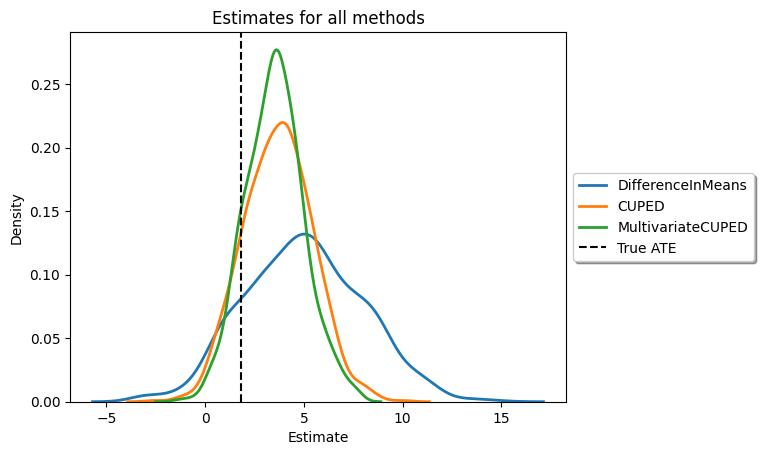

<Axes: title={'center': 'Estimates for all methods'}, xlabel='Estimate', ylabel='Density'>

In [23]:
cupeds_evaluation3.plot(plot_what='estimates')